In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Display plots directly in the notebook
%matplotlib inline 
sns.set_theme(style="whitegrid")

# --- PATHS ---
BASE_DIR = "/home/marcos/PRJEB59406"
INPUT_FILE = f"{BASE_DIR}/abundance_results/unified_abundance_with_groups.tsv"
OUTPUT_DIR = f"{BASE_DIR}/abundance_results/plots"

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Setup complete.")

Ambiente configurado!
Lendo arquivo: /home/marcos/PRJEB59406/abundance_results/unified_abundance_with_groups.tsv


In [5]:
# Load the unified table
df = pd.read_csv(INPUT_FILE, sep="\t")

# Check available columns
print(f"Columns: {list(df.columns)}")

# Preview the data
display(df.head())

# Check group distribution
if 'Group' in df.columns:
    print("\nSamples per Group:")
    print(df['Group'].value_counts())
else:
    print("Error: 'Group' column not found!")

Columns: ['CDS', 'Protein', 'Abundance', 'Sample', 'Group']


,CDS,Protein,Abundance,Sample,Group
0,k141_185403_1,.nanH_4766_bv,66468.253968,ERR10856994,Control
1,k141_185403_1,.nanH_18728_bv,66468.253968,ERR10856994,Control
2,k141_185403_1,.nanH_33967_bv,66468.253968,ERR10856994,Control
3,k141_185403_1,.nanH_30699_bv,66468.253968,ERR10856994,Control
4,k141_185403_1,.nanH_62862_bv,66468.253968,ERR10856994,Control



Samples per Group:
Group
Control    806
Name: count, dtype: int64


Heatmap

/tmp/ipykernel_77351/68390697.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_matrix = matrix.groupby(sample_to_group, axis=1).mean()


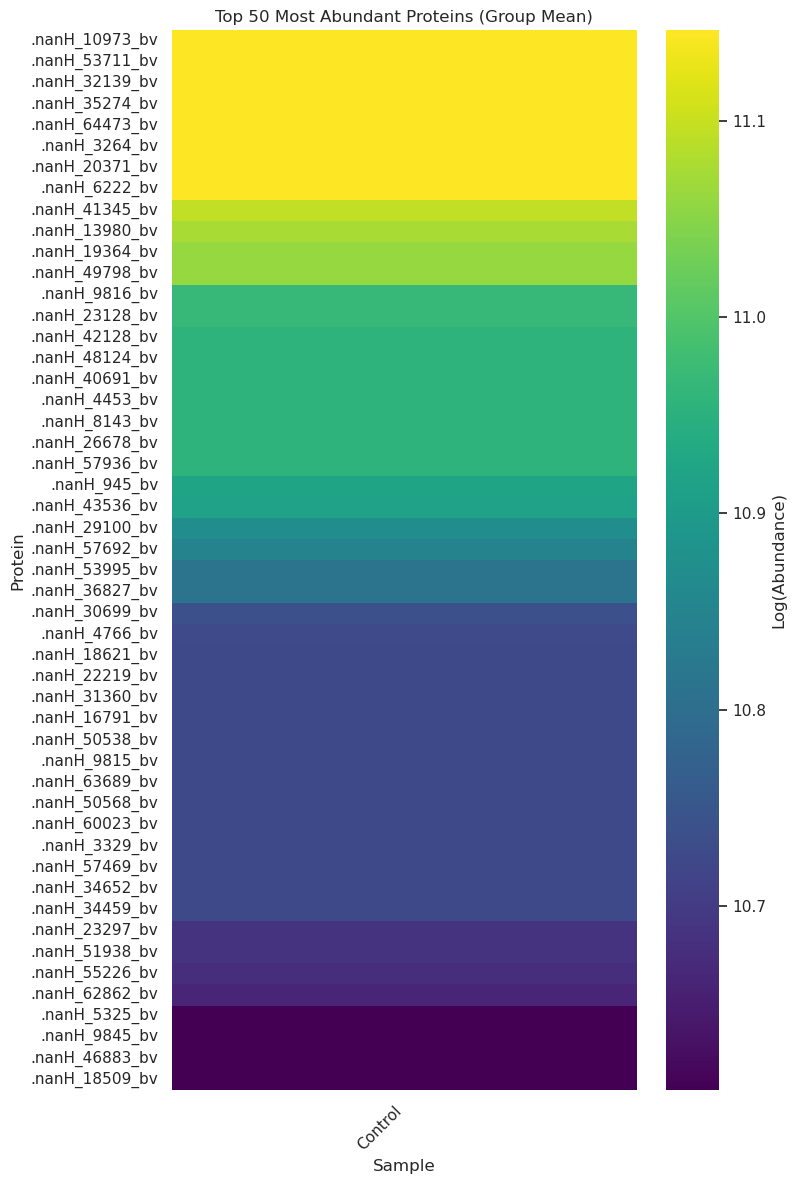

In [6]:
# 1. Prepare Data
id_col = 'Protein' if 'Protein' in df.columns else 'CDS'

# Create Matrix: Rows=Protein, Cols=Sample, Values=Abundance
matrix = df.pivot_table(index=id_col, columns="Sample", values="Abundance", aggfunc="sum").fillna(0)

# Map Samples to Groups and calculate Mean per Group
sample_to_group = dict(zip(df['Sample'], df['Group']))
grouped_matrix = matrix.groupby(sample_to_group, axis=1).mean()

# 2. Select Top 50 (by overall mean)
grouped_matrix['mean_val'] = grouped_matrix.mean(axis=1)
top50 = grouped_matrix.sort_values('mean_val', ascending=False).head(50).drop(columns=['mean_val'])

# 3. Plot Heatmap (Log Scale)
plt.figure(figsize=(8, 12))
sns.heatmap(np.log1p(top50), cmap='viridis', annot=False, cbar_kws={'label': 'Log(Abundance)'})

plt.title("Top 50 Most Abundant Proteins (Group Mean)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Protein")
plt.tight_layout()

plt.savefig(f"{OUTPUT_DIR}/heatmap_top50.png", dpi=300)
plt.show()